In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv
from sklearn.metrics import accuracy_score
import seaborn as sns
import pylab
from sklearn import neighbors
from sklearn.model_selection import train_test_split

In [2]:
from os import listdir
a_traincsv = listdir('Desktop/sepsiss/training_setA/training/')
b_traincsv = listdir('Desktop/sepsiss/training_setB/training_setB/')

In [3]:
with open('train_patient.csv', 'w') as csvoutput:
  writer = csv.writer(csvoutput, lineterminator='\n')

  for ind, csv_name in enumerate(a_traincsv):
    with open('Desktop/sepsiss/training_setA/training/'+ csv_name,'r') as csvinput:
      reader = csv.reader(csvinput, delimiter='|')
      all = []
      if ind ==0 :
        row = next(reader)
        row.append('Patient_id')
        row.append('time')
        all.append(row)
      else:
        row = next(reader)

      for i,row in enumerate(reader):
        row.append(ind)
        row.append(i)
        all.append(row)
      writer.writerows(all)
    
  num = ind 
  for inde, csv_name in enumerate(b_traincsv):
    if inde < 10000:
      num = num+1
      with open('Desktop/sepsiss/training_setB/training_setB/'+ csv_name,'r') as csvinput:
        reader = csv.reader(csvinput, delimiter='|')
        all = []
        row = next(reader)
        for i,row in enumerate(reader):
          row.append(num)
          row.append(i)
          all.append(row)
        
        writer.writerows(all)
        

with open('val_patient.csv', 'w') as csvoutput:
  writer = csv.writer(csvoutput, lineterminator='\n')

  for inde, csv_name in enumerate(b_traincsv):
    if inde >=10000 and inde <15000:
      with open('Desktop/sepsiss/training_setB/training_setB/'+ csv_name,'r') as csvinput:
        reader = csv.reader(csvinput, delimiter='|')
        all = []
        if inde ==10000 :
          row = next(reader)
          row.append('Patient_id')
          row.append('time')
          all.append(row)
        else:
          row = next(reader)
        for i,row in enumerate(reader):
          row.append(inde)
          row.append(i)
          all.append(row)
        writer.writerows(all)
        

with open('test_patient.csv', 'w') as csvoutput:
  writer = csv.writer(csvoutput, lineterminator='\n')

  for inde, csv_name in enumerate(b_traincsv):
    if inde >=15000:
      with open('Desktop/sepsiss/training_setB/training_setB/'+ csv_name,'r') as csvinput:
        reader = csv.reader(csvinput, delimiter='|')
        all = []
        if inde ==15000 :
          row = next(reader)
          row.append('Patient_id')
          row.append('time')
          all.append(row)
        else:
          row = next(reader)
        for i,row in enumerate(reader):
          row.append(inde)
          row.append(i)
          all.append(row)

        writer.writerows(all)


In [4]:
# All about training Set

In [5]:
train = pd.read_csv('train_patient.csv')
train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,124.0,98.0,36.78,121.0,72.0,51.0,23.0,NaN,NaN,18.0,...,267.0,71.44,1,1.0,0.0,-0.02,3,0,0,0
1,116.0,97.0,NaN,124.0,77.0,57.0,22.0,NaN,NaN,NaN,...,NaN,71.44,1,1.0,0.0,-0.02,4,0,0,1
2,118.0,96.0,NaN,104.0,64.0,47.0,23.0,NaN,NaN,NaN,...,NaN,71.44,1,1.0,0.0,-0.02,5,0,0,2
3,114.0,98.0,NaN,118.0,71.0,52.0,20.0,NaN,NaN,NaN,...,NaN,71.44,1,1.0,0.0,-0.02,6,0,0,3
4,109.0,98.0,NaN,122.0,73.0,51.0,21.0,NaN,NaN,NaN,...,NaN,71.44,1,1.0,0.0,-0.02,7,0,0,4


In [6]:
filter_cols = ['Patient_id', 'time', 'HR', 'Age', 'MAP', 'Resp', 'Temp', 'WBC', 
               'PaCO2', 'SepsisLabel']

filter_train = train[filter_cols]
filter_train.head()

,Patient_id,time,HR,Age,MAP,Resp,Temp,WBC,PaCO2,SepsisLabel
0,0,0,124.0,71.44,72.0,23.0,36.78,14.0,NaN,0
1,0,1,116.0,71.44,77.0,22.0,NaN,NaN,NaN,0
2,0,2,118.0,71.44,64.0,23.0,NaN,NaN,NaN,0
3,0,3,114.0,71.44,71.0,20.0,NaN,NaN,NaN,0
4,0,4,109.0,71.44,73.0,21.0,NaN,NaN,NaN,0


In [7]:
#Total number of patient
len(filter_train['Patient_id'].unique())

30336

In [8]:
#total no of patient with sepsis
grp_sepsis_rep = np.array(filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())

len(grp_sepsis_rep[grp_sepsis_rep > 0])

2321

In [9]:
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())

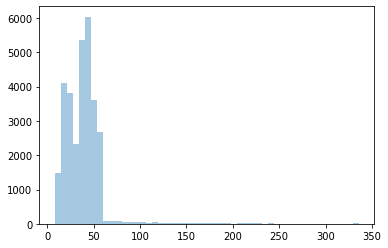

In [10]:
sns.distplot(agg_patient_time,kde=False)

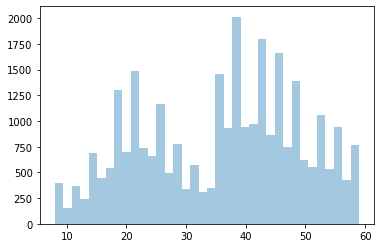

In [11]:
#We can remove those patients with more than 60 hours in the hospital. 
#These patients (more than 60 hours in hospital) are considered outliers .
#The reason behind this is that we will be using LSTM for modeling and window of size 350 won't be a great idea.
agg_patient_time = np.array(filter_train.groupby(['Patient_id'])['SepsisLabel']\
                            .count())
agg_patient_time = agg_patient_time[agg_patient_time < 60]
sns.distplot(agg_patient_time,kde=False)

In [12]:
#Removing patient with 60hrs of data

In [13]:
temp = filter_train.groupby(['Patient_id'])['SepsisLabel'].count().reset_index()

In [14]:
sel_pid = np.array(temp[temp['SepsisLabel'] <=60]['Patient_id'])

In [15]:
patient_filter_train = filter_train[filter_train['Patient_id'].isin(sel_pid)]

In [16]:
len(patient_filter_train['Patient_id'].unique())

29409

In [17]:
#Total Number of Patients with Sepsis after filtering patients with > 60 hours
grp_sepsis_rep = np.array(patient_filter_train.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())
len(grp_sepsis_rep[grp_sepsis_rep > 0])

1511

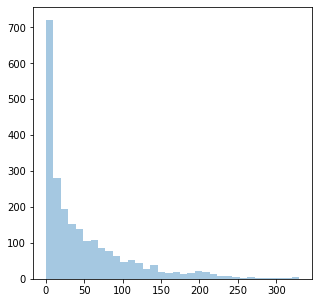

In [18]:
#Counting the time at which patient comes in contact with the sepsis
temp = filter_train.groupby(['Patient_id'])['SepsisLabel']\
       .sum().reset_index()
sepsis_train_pid = np.array(temp[temp['SepsisLabel'] > 0]['Patient_id'])
temp_filter = filter_train[filter_train['Patient_id']\
                                   .isin(sepsis_train_pid)]
sepsis_time = []
tot_time = []
for pid in sepsis_train_pid:
  df = temp_filter[temp_filter['Patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])
pylab.rcParams['figure.figsize'] = 5, 5
sns.distplot(sepsis_time, kde=False)

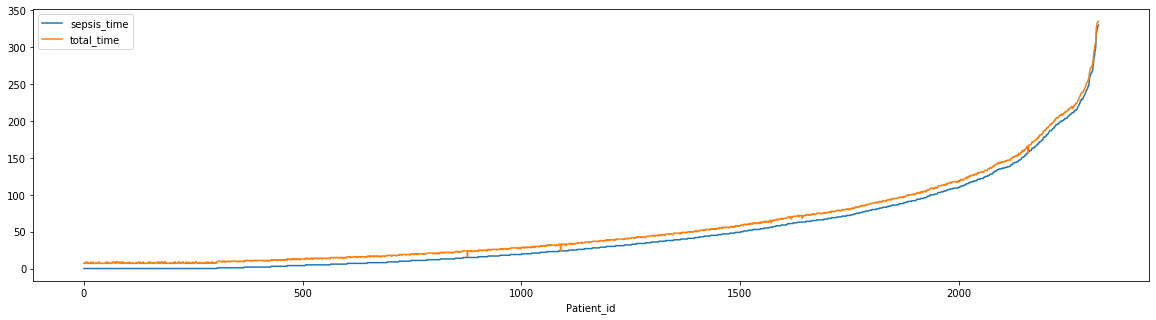

In [19]:
temp = pd.DataFrame()
temp['pid'] = sepsis_train_pid
temp['sepsis_time'] = sepsis_time
temp['tot_time'] = tot_time
temp.sort_values(by=['sepsis_time'], inplace=True)
temp['level'] = temp.reset_index().index
pylab.rcParams['figure.figsize'] = 20, 5
plt.plot(temp['level'], temp['sepsis_time'])
plt.plot(temp['level'], temp['tot_time'])
_ = plt.xlabel('Patient_id')
_ = plt.legend(['sepsis_time', 'total_time'])

In [20]:
pids = np.array(filter_train['Patient_id'].unique())
missing_dict = {}
pid_missing_dict = {}
for col in ['HR','MAP', 'Resp', 'Temp','WBC', 'PaCO2']:
  missing_dict[col] = []
  pid_missing_dict[col] = []
  for pid in pids:
    temp = filter_train[filter_train['Patient_id'] == pid]
    missing = (temp[col].isnull().sum() / temp.shape[0]) * 100
    missing_dict[col].append(missing)
    if missing > 99:
      pid_missing_dict[col].append(pid)

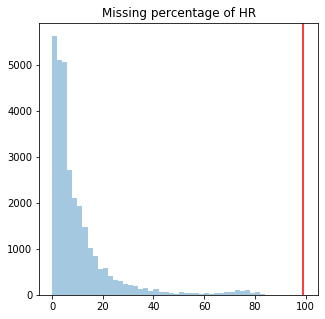

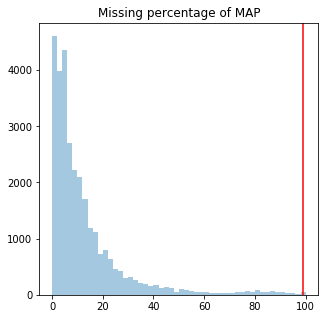

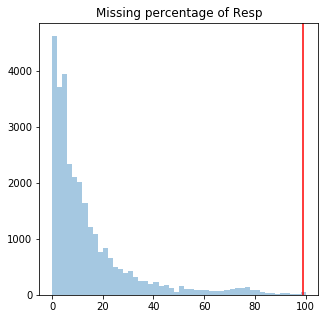

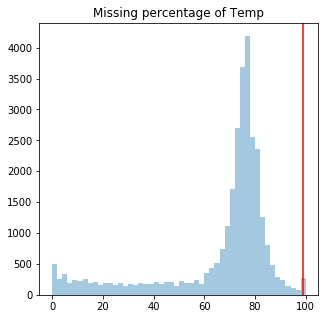

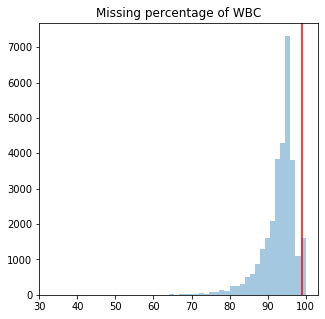

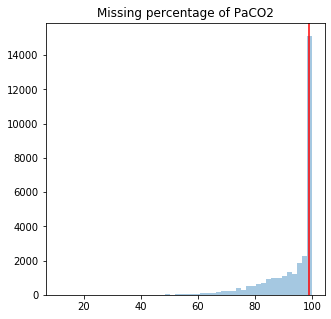

In [21]:
pylab.rcParams['figure.figsize'] = 5, 5
for i,col in enumerate(missing_dict.keys()):
  plt.figure(i)
  plt.axvline(99, 0,90, color='r')

  plt.title("Missing percentage of " + str(col))
  sns.distplot(missing_dict[col], kde=False);

In [22]:
#Number of Patients with 100 % missing data for Columns

In [23]:
#HeartRate
arr = np.array(missing_dict['HR'])

(len(arr[arr >99]) / 30336) * 100

0.0065928270042194086

In [24]:
#map
arr = np.array(missing_dict['MAP'])

(len(arr[arr >99]) / 30336) * 100

0.17141350210970466

In [25]:
#Resp
arr = np.array(missing_dict['Resp'])

(len(arr[arr >99]) / 30336) * 100

0.16811708860759494

In [26]:
#Temp
arr = np.array(missing_dict['Temp'])

(len(arr[arr >99]) / 30336) * 100

0.8471782700421941

In [27]:
#WBC
arr = np.array(missing_dict['WBC'])

(len(arr[arr >99]) / 30336) * 100

5.330300632911392

In [28]:
#PACO2
arr = np.array(missing_dict['PaCO2'])

(len(arr[arr >99]) / 30336) * 100

49.22534282700422

In [29]:
#Total Number of Patients with 100% NA in atleast one of the column
len(set.union(set(pid_missing_dict['HR']), set(pid_missing_dict['MAP']), 
          set(pid_missing_dict['Resp']), set(pid_missing_dict['Temp']), 
          set(pid_missing_dict['WBC'])))

1901

In [30]:
#Total Number of Patients with sepsis and 100% NA in atleast one of the columns
na_pid_union = set.union(set(pid_missing_dict['HR']), set(pid_missing_dict['MAP']), 
          set(pid_missing_dict['Resp']), set(pid_missing_dict['Temp']), 
          set(pid_missing_dict['WBC']))

In [31]:
len(na_pid_union & set(sepsis_train_pid))

219

In [32]:
train[~train['Patient_id'].isin(na_pid_union)].to_csv('updated_train.csv', index=False)

In [33]:
train_copy = train.groupby('Patient_id').mean().fillna(train.mean())

In [34]:
train_copy.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,time
Patient_id,,,,,,,,,,,,,,,,,,,,,
0,108.072727,96.672727,36.588947,127.418182,80.490727,59.836364,21.809091,33.076474,-1.800000,18.666667,...,290.176375,237.50,71.44,1.0,1.000000,0.000000,-0.02,31.0,0.000000,28.0
1,78.583333,96.166667,37.186667,116.916667,79.666667,62.743065,16.250000,33.076474,-0.669369,26.000000,...,290.176375,191.00,59.05,0.0,0.501491,0.498509,-66.26,10.0,0.000000,9.0
2,67.714286,97.437500,36.540000,132.037037,72.802593,62.743065,15.764706,33.076474,-0.669369,27.000000,...,290.176375,170.00,70.19,0.0,1.000000,0.000000,-7.89,19.5,0.000000,18.5
3,92.716418,93.828358,37.673500,111.865672,81.544776,67.880597,23.514925,33.076474,-0.769231,23.000000,...,290.176375,109.00,66.42,1.0,0.000000,1.000000,-14.44,36.0,0.134328,33.0
4,85.170000,94.310000,36.878000,105.500000,73.255102,54.222222,19.420000,33.076474,-0.375000,25.750000,...,290.176375,125.25,55.46,1.0,0.000000,1.000000,-0.02,31.5,0.000000,24.5


In [35]:
#Converting sepsisLabel value more than 0 to 1 
train_copy['SepsisLabel'][train_copy['SepsisLabel']!=0] = 1

In [36]:
x = train_copy.drop(['SepsisLabel'],axis = 1)

In [37]:
y = train_copy['SepsisLabel']

In [38]:
#All about test set

In [39]:
test = pd.read_csv('test_patient.csv')

In [40]:
test.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,24,0,1.0,0.0,-5.45,1,0,15000,0
1,76.0,100.0,NaN,201.0,145.0,108.0,20.0,NaN,NaN,NaN,...,NaN,24,0,1.0,0.0,-5.45,2,0,15000,1
2,77.0,100.0,36.4,220.0,155.0,110.0,22.0,NaN,NaN,NaN,...,NaN,24,0,1.0,0.0,-5.45,3,0,15000,2
3,85.0,100.0,NaN,196.0,147.0,110.0,20.0,NaN,NaN,NaN,...,145.0,24,0,1.0,0.0,-5.45,4,0,15000,3
4,87.0,NaN,35.9,201.0,154.0,116.0,20.0,NaN,NaN,NaN,...,NaN,24,0,1.0,0.0,-5.45,5,0,15000,4


In [41]:
test_copy = test.fillna(train.mean())

In [42]:
test_copy.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,197.387781,24,0,1.0,0.0,-5.45,1,0,15000,0
1,76.00000,100.000000,36.992492,201.000000,145.000000,108.000000,20.000000,33.076474,-0.669369,24.084047,...,197.387781,24,0,1.0,0.0,-5.45,2,0,15000,1
2,77.00000,100.000000,36.400000,220.000000,155.000000,110.000000,22.000000,33.076474,-0.669369,24.084047,...,197.387781,24,0,1.0,0.0,-5.45,3,0,15000,2
3,85.00000,100.000000,36.992492,196.000000,147.000000,110.000000,20.000000,33.076474,-0.669369,24.084047,...,145.000000,24,0,1.0,0.0,-5.45,4,0,15000,3
4,87.00000,97.215386,35.900000,201.000000,154.000000,116.000000,20.000000,33.076474,-0.669369,24.084047,...,197.387781,24,0,1.0,0.0,-5.45,5,0,15000,4


In [43]:
x_test = test_copy.drop(['SepsisLabel','Patient_id'],axis = 1)

In [44]:
x_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,time
0,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,24,0,1.0,0.0,-5.45,1,0
1,76.00000,100.000000,36.992492,201.000000,145.000000,108.000000,20.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,24,0,1.0,0.0,-5.45,2,1
2,77.00000,100.000000,36.400000,220.000000,155.000000,110.000000,22.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,24,0,1.0,0.0,-5.45,3,2
3,85.00000,100.000000,36.992492,196.000000,147.000000,110.000000,20.000000,33.076474,-0.669369,24.084047,...,6.600000,290.176375,145.000000,24,0,1.0,0.0,-5.45,4,3
4,87.00000,97.215386,35.900000,201.000000,154.000000,116.000000,20.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,24,0,1.0,0.0,-5.45,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188191,80.00000,100.000000,36.500000,148.000000,80.000000,56.000000,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,71,1,0.0,1.0,-78.99,47,46
188192,80.00000,100.000000,36.200000,139.000000,77.000000,54.000000,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,71,1,0.0,1.0,-78.99,48,47
188193,80.00000,100.000000,36.050000,135.500000,75.500000,53.500000,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,71,1,0.0,1.0,-78.99,49,48
188194,80.00000,100.000000,35.900000,138.000000,77.000000,54.000000,14.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,71,1,0.0,1.0,-78.99,50,49


In [45]:
y_test = test_copy['SepsisLabel']

In [46]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
188191    0
188192    0
188193    0
188194    0
188195    0
Name: SepsisLabel, Length: 188196, dtype: int64

In [47]:
val = pd.read_csv('val_patient.csv')

In [48]:
val = val.fillna(train.mean())

In [49]:
val.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,197.387781,79,0,1.0,0.0,-122.41,1,0,10000,0
1,92.00000,100.000000,36.992492,117.000000,101.000000,71.000000,18.000000,33.076474,-0.669369,24.084047,...,197.387781,79,0,1.0,0.0,-122.41,2,0,10000,1
2,90.00000,97.500000,36.992492,115.000000,89.000000,67.000000,17.500000,33.076474,-0.669369,24.084047,...,197.387781,79,0,1.0,0.0,-122.41,3,0,10000,2
3,72.00000,98.000000,36.992492,110.000000,81.000000,64.000000,17.000000,33.076474,-0.669369,24.084047,...,197.387781,79,0,1.0,0.0,-122.41,4,0,10000,3
4,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,197.387781,79,0,1.0,0.0,-122.41,5,0,10000,4


In [50]:
len(val)

192060

In [51]:
x_val = val.drop(['SepsisLabel', 'Patient_id'], axis=1)

In [52]:
x_val

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,time
0,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,79,0,1.000000,0.000000,-122.41,1,0
1,92.00000,100.000000,36.992492,117.000000,101.000000,71.000000,18.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,79,0,1.000000,0.000000,-122.41,2,1
2,90.00000,97.500000,36.992492,115.000000,89.000000,67.000000,17.500000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,79,0,1.000000,0.000000,-122.41,3,2
3,72.00000,98.000000,36.992492,110.000000,81.000000,64.000000,17.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,79,0,1.000000,0.000000,-122.41,4,3
4,84.67723,97.215386,36.992492,122.748613,81.127775,62.743065,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,79,0,1.000000,0.000000,-122.41,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192055,75.00000,98.000000,36.000000,115.000000,92.000000,78.000000,18.735646,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,39,0,0.501491,0.498509,-4.92,46,45
192056,73.00000,98.000000,36.992492,143.000000,108.000000,85.000000,16.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,39,0,0.501491,0.498509,-4.92,47,46
192057,75.00000,97.000000,36.992492,148.000000,109.000000,84.000000,17.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,39,0,0.501491,0.498509,-4.92,48,47
192058,75.00000,98.000000,36.992492,130.000000,91.000000,66.000000,18.000000,33.076474,-0.669369,24.084047,...,11.622927,290.176375,197.387781,39,0,0.501491,0.498509,-4.92,49,48


In [53]:
y_val = val['SepsisLabel']

In [54]:
y_val

0         0
1         0
2         0
3         0
4         0
         ..
192055    0
192056    0
192057    0
192058    0
192059    0
Name: SepsisLabel, Length: 192060, dtype: int64

In [55]:
#Counting no of 1's and no of 0's

In [56]:
y.value_counts()

0.0    28015
1.0     2321
Name: SepsisLabel, dtype: int64

In [57]:
clf = neighbors.KNeighborsClassifier()

In [58]:
clf.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
y_pred = clf.predict(x)

In [60]:
accuracy_score(y_pred, y)

0.9348628691983122

In [61]:
y_pred = clf.predict(x_test)

In [62]:
accuracy_score(y_pred, y_test)

0.9363270207655848

In [63]:
y_pred = clf.predict(x_val)

In [64]:
accuracy_score(y_pred, y_val)

0.9254139331458919

In [65]:
from sklearn import metrics

In [66]:
y_pred = clf.predict(x_test)

In [67]:
accuracy_score(y_pred, y_test)

0.9363270207655848

In [68]:
cm = metrics.confusion_matrix(y_test, y_pred)

In [69]:
cm

array([[175526,   9943],
       [  2040,    687]])

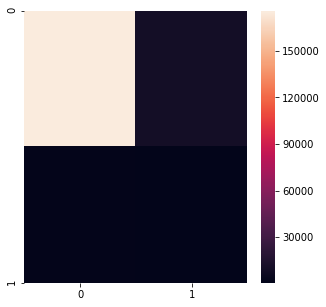

In [70]:
sns.heatmap(cm)

In [71]:
corrmat = train.corr()['SepsisLabel']

In [72]:
corrmat

HR                  0.049267
O2Sat              -0.008254
Temp                0.045743
SBP                -0.012382
MAP                -0.016315
DBP                -0.013194
Resp                0.049117
EtCO2              -0.005802
BaseExcess          0.016229
HCO3               -0.013879
FiO2               -0.000133
pH                 -0.006343
PaCO2               0.018993
SaO2                0.009781
AST                 0.011553
BUN                 0.052178
Alkalinephos        0.013133
Calcium            -0.033683
Chloride           -0.011011
Creatinine          0.026320
Bilirubin_direct    0.062844
Glucose             0.010614
Lactate             0.009632
Magnesium           0.003438
Phosphate           0.017283
Potassium           0.005862
Bilirubin_total     0.053385
TroponinI           0.001973
Hct                -0.013073
Hgb                -0.018127
PTT                 0.019033
WBC                 0.038500
Fibrinogen          0.044822
Platelets          -0.009642
Age           